<a href="https://colab.research.google.com/github/poponzu/Research/blob/master/%5B%E6%80%A7%E8%83%BD%E8%A9%95%E4%BE%A1%5DLSTM%E8%A4%87%E6%95%B0%E5%85%A5%E5%8A%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <span style="color: red">実行前にデバッグモードであるかどうか、train_start, test_start, data_endの値, 学習回数epochsを確認！</span>

In [434]:
# debug = 1はデバック（動作確認用)
debug = 0

In [435]:
# データの範囲指定
if debug:
  train_start = 2000
  test_start = 2490
  data_end = 2500
else: 
  train_start = 2000
  test_start = 6500
  data_end = 7000

# 学習回数
if debug:
  epochs = 1
else:
  epochs = 2

## このノートブックのLSTMモデルは[これ](https://qiita.com/tsubauaaa/items/8411a22465811ec2ee11#%E5%AD%A6%E7%BF%92%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E3%82%B7%E3%83%BC%E3%82%B1%E3%83%B3%E3%82%B9%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E5%8F%96%E5%BE%97)を参考に作成した！

In [436]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [437]:
# deviceの作成
# device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'

In [438]:
device

'cpu'

In [439]:
# Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [440]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")

In [441]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [442]:
len_data = data.shape[0]

# 使用する特徴量を指定する

In [443]:
Bike_data = data[['cnt', 'temp', 'registered']]

# 特徴量を時系列にグラフ表示

In [444]:
# fig, (axL, axM, axR) = plt.subplots(ncols=3, figsize=(20,5))

# axL.plot(Bike_data['cnt'], linewidth=2)
# axL.set_title('Number of Bike sharing cnt')
# axL.set_xlabel('2012/1/1-2013/12/31')
# axL.set_ylabel('cnt')
# axL.grid(True)
# axL.vlines(x=2000, ymin=0, ymax=1000, colors='red', linestyles='dotted')
# axL.vlines(x=6500, ymin=0, ymax=1000, colors='black', linestyles='dotted')
# axL.vlines(x=7000, ymin=0, ymax=1000, colors='red', linestyles='dotted')


# axM.plot(Bike_data['temp'], linewidth=2)
# axM.set_title('tempeture')
# axM.set_xlabel('2012/1/1-2013/12/31')
# axM.set_ylabel('temp')
# axM.grid(True)
# axM.vlines(x=2000, ymin=0, ymax=1, colors='red', linestyles='dotted')
# axM.vlines(x=6500, ymin=0, ymax=1, colors='black', linestyles='dotted')
# axM.vlines(x=7000, ymin=0, ymax=1, colors='red', linestyles='dotted')

# axR.plot(Bike_data['registered'], linewidth=2)
# axR.set_title('Number of registered')
# axR.set_xlabel('2012/1/1-2013/12/31')
# axR.set_ylabel('registered')
# axR.grid(True)
# axR.vlines(x=2000, ymin=0, ymax=800, colors='red', linestyles='dotted')
# axR.vlines(x=6500, ymin=0, ymax=800, colors='black', linestyles='dotted')
# axR.vlines(x=7000, ymin=0, ymax=800, colors='red', linestyles='dotted')

# fig.show()

# 軽量化のためデータ量を調節

In [445]:
Bike_data = Bike_data[train_start:data_end]

In [446]:
Bike_data = Bike_data.values.astype(float)
Bike_data.shape

(5000, 3)

# 学習データとテストデータに分割する

In [447]:
test_data_size = data_end - test_start

train_data = Bike_data[:-test_data_size]
test_data = Bike_data[-test_data_size:]

In [448]:
#train_dataの正規化
# データセットの正規化を行う。最小値0と最大値1の範囲で行う。
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [449]:
# Tensor型に変換
train_data_normalized = torch.FloatTensor(train_data_normalized)

In [450]:
# シーケンスに沿ったデータを作成する関数
def make_sequence_data(input_data, num_sequence):
    # シーケンスデータとラベルデータの器
    data = []
    # 全体のデータ数取得
    num_data = len(input_data)
    # 全体からシーケンス分引いた数までループする
    for i in range(num_data - num_sequence):
        # 1個ずらして、シーケンス分のデータを取得していく
        seq_data = input_data[i:i+num_sequence]
        # シーケンスの次の要素のデータ(ラベルデータとして1個目の陽性者数のみ)を取得していく
        target_data = input_data[:,0][i+num_sequence:i+num_sequence+1]
        # シーケンスデータとラベルデータをタプルとして取得していく
        data.append((seq_data, target_data))

    return data

In [451]:
# シーケンス長は24データとする
# 24時間分のデータから次の1日後のデータを予測する
# 48時間とかにしてもよいかも
seq_length = 24
# train_seq_data=最初のデータを1個ずらしてシーケンス分のデータ(時系列の学習データ群)、train_target=train_seq_dataの次のデータ(ラベルデータ)
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

In [452]:
train_data_normalized[:3]

tensor([[0.0108, 0.0000, 0.0141],
        [0.0754, 0.0000, 0.0811],
        [0.2031, 0.0000, 0.2257]])

In [453]:
# train_seq_data[:3]

In [454]:
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)にする
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)となる
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)にする
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力する
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [455]:
device

'cpu'

In [456]:
device = 'cpu'

In [457]:
model = LSTM()
model.to(device)

LSTM(
  (lstm): LSTM(3, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [458]:
# 損失関数と最適化関数を定義
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

 50%|█████     | 1/2 [00:29<00:29, 29.83s/it]

epoch: 0, loss : 0.05060186609625816


100%|██████████| 2/2 [00:58<00:00, 29.01s/it]

epoch: 1, loss : 0.028165435418486595


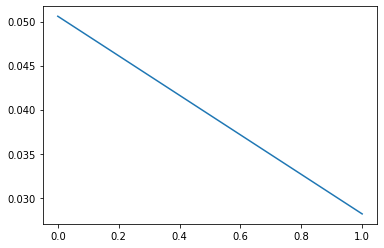

In [459]:
import tqdm

losses = []
for i in tqdm.tqdm(range(epochs)):
    for seq, labels in train_seq_data:
        # seq, labelsのshapeは(seq_length, 特徴量)なのでLSTMに渡すために(batch, seq_length, 特徴量)にする。(batch=1)
        seq, labels = torch.unsqueeze(seq, 0), torch.unsqueeze(labels, 0)
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    losses.append(single_loss.item())
    print(f'epoch: {i}, loss : {single_loss.item()}')

# 学習時の損失をグラフ表示
plt.plot(losses)

In [460]:
# 予測する日数
pred_days = test_data_size
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換する。
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()

In [461]:
seq_length

24

In [462]:
# モデルを評価モードとする
model.eval()
# 予測値を入れるリスト
test_outputs = []
for i in range(pred_days):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    seq = torch.unsqueeze(seq, 0)
    seq = seq.to(device)
    with torch.no_grad():
        test_inputs.append(test_data_normalized.tolist()[i])
        test_outputs.append(model(seq).item())

#  出力結果を入力の列に使った特徴量の次元に合わせてここは変更する必要あり。(関数化したいけど、あとで）

In [463]:
np_test_outputs = np.array(test_outputs).reshape(-1,1)
# 列方向に同じ値を追加して(30, 3)にする
np_test_outputs2 = np.hstack((np_test_outputs, np_test_outputs))
np_test_outputs3 = np.hstack((np_test_outputs2, np_test_outputs))
actual_predictions = scaler.inverse_transform(np_test_outputs3)

In [464]:
# 関数化を試みるも面倒(10/5時点)
def stack(outputs, dim):
  np_outputs1 = np.array(outputs).reshape(-1,1)

In [465]:
test_data_size

500

In [466]:
# 予測値のx軸の値の設定
x = np.arange(test_start, data_end, 1)
print(x,test_data_size)

[6500 6501 6502 6503 6504 6505 6506 6507 6508 6509 6510 6511 6512 6513
 6514 6515 6516 6517 6518 6519 6520 6521 6522 6523 6524 6525 6526 6527
 6528 6529 6530 6531 6532 6533 6534 6535 6536 6537 6538 6539 6540 6541
 6542 6543 6544 6545 6546 6547 6548 6549 6550 6551 6552 6553 6554 6555
 6556 6557 6558 6559 6560 6561 6562 6563 6564 6565 6566 6567 6568 6569
 6570 6571 6572 6573 6574 6575 6576 6577 6578 6579 6580 6581 6582 6583
 6584 6585 6586 6587 6588 6589 6590 6591 6592 6593 6594 6595 6596 6597
 6598 6599 6600 6601 6602 6603 6604 6605 6606 6607 6608 6609 6610 6611
 6612 6613 6614 6615 6616 6617 6618 6619 6620 6621 6622 6623 6624 6625
 6626 6627 6628 6629 6630 6631 6632 6633 6634 6635 6636 6637 6638 6639
 6640 6641 6642 6643 6644 6645 6646 6647 6648 6649 6650 6651 6652 6653
 6654 6655 6656 6657 6658 6659 6660 6661 6662 6663 6664 6665 6666 6667
 6668 6669 6670 6671 6672 6673 6674 6675 6676 6677 6678 6679 6680 6681
 6682 6683 6684 6685 6686 6687 6688 6689 6690 6691 6692 6693 6694 6695
 6696 

# 予測結果と実際の値を同じ図に図示する

In [467]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

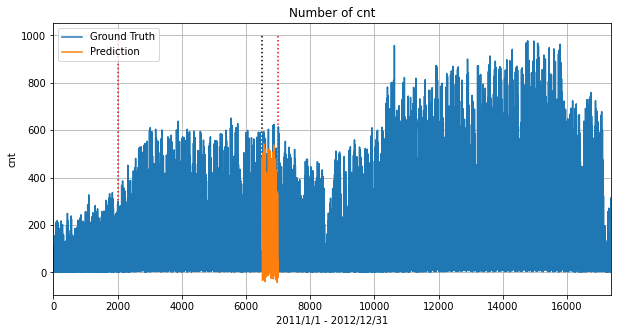

In [468]:
plt.title('Number of cnt')
plt.ylabel('cnt')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['cnt'], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2011/1/1 - 2012/12/31')
plt.legend()
plt.vlines(x=train_start, ymin=0, ymax=1000, colors='red', linestyles='dotted')
plt.vlines(x=test_start, ymin=0, ymax=1000, colors='black', linestyles='dotted')
plt.vlines(x=data_end, ymin=0, ymax=1000, colors='red', linestyles='dotted')
plt.show()

# 予測部分拡大ver

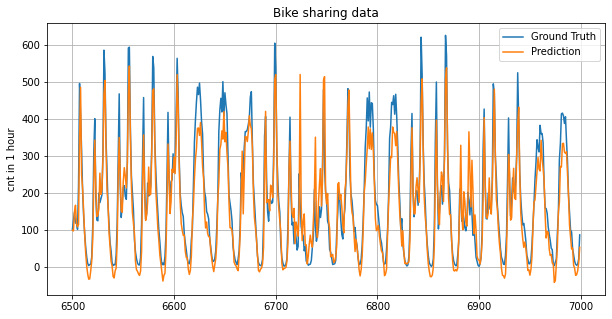

In [469]:
plt.title('Bike sharing data')
plt.ylabel('cnt in 1 hour')
plt.grid(True)
plt.plot(data["cnt"][test_start:data_end], label='Ground Truth')
plt.plot(x,actual_predictions[:,0], label='Prediction')
plt.legend()
plt.show()

## 考察
# 日毎のデータでもLSTMモデル立ててもいいかも

## 損失の値を出す

In [470]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")
data = data["cnt"][test_start:data_end]
data = data.values.astype(np.float32)
data = torch.from_numpy(data)
b = torch.from_numpy(actual_predictions[:,0])
criterion = nn.MSELoss()
loss = criterion(data, b)
loss

tensor(3331.0777, dtype=torch.float64)

In [471]:
len(data)

500

In [472]:
len(b)

500